TASK 2:-
1) you use EstimatorV2 from qiskit_aer.primitives, 
2) use the preset_pass_manager from qiskit.transpiler at different levels of optimization 0,1,2,3 and check the depth and width of the generated quantum circuits, 
3) likewise perform VQE without using the VQE class from qiskit_algorithms.

In [24]:
import qiskit_nature
import pyscf

print("Qiskit Nature version:", qiskit_nature.__version__)
print("PySCF version:", pyscf.__version__)


Qiskit Nature version: 0.7.2
PySCF version: 2.8.0


In [25]:
#USES ESTIMATORV2 + RUNS ACTUAL VQE USING COST FUNC (NO VQE CLASS) + TRANSPILES AT ALL 4 OPT LEVELS + TELLS THE WIDTH AND DEPTH + STORES CONVERGENCE VALUES FOR GRAPH PLOTTING

from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
from qiskit.quantum_info import SparsePauliOp
from qiskit_aer.primitives import EstimatorV2
from qiskit.providers.basic_provider import BasicSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from scipy.optimize import minimize
import numpy as np
convergence_data = {}


backend = BasicSimulator()

# Defining molecule and mapping hamiltoninan
driver = PySCFDriver(atom="H 0 0 0; H 0 0 0.735", basis="sto3g")
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
mapper = JordanWignerMapper()
qubit_op = mapper.map(hamiltonian)

# Creating ansatz circuit
num_particles = problem.num_particles
num_spatial_orbitals = problem.num_spatial_orbitals
hf_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
ansatz = UCCSD(num_spatial_orbitals, num_particles, mapper, initial_state=hf_state)

#---------------------------------------------------------------------
for level in range(4):
    print(f"\n Optimization Level {level} ")

    # Transpile ansatz with diff optimization levels
    pm = generate_preset_pass_manager(backend=backend, optimization_level=level)
    transpiled_ansatz = pm.run(ansatz)
    initial_params = np.zeros(transpiled_ansatz.num_parameters)
    print(f"\nInitial paras {initial_params} ")
    print("Circuit depth:", transpiled_ansatz.depth())
    print("Circuit width:", transpiled_ansatz.width())

    observable = qubit_op.apply_layout(transpiled_ansatz.layout)
    estimator = EstimatorV2()
    cost_history_dict = {
        "prev_vector":None,
        "iters": 0,
        "cost_history": [],
    }

    
    def cost_func(params):
        pub = (transpiled_ansatz, [observable], [params])
        result = estimator.run([pub]).result()
        energy = result[0].data.evs[0]
        cost_history_dict["iters"] += 1
        cost_history_dict["prev_vector"] = params
        cost_history_dict["cost_history"].append(energy)
        print(f"  Iteration {cost_history_dict['iters']} -> Energy: {energy:.6f}")
        return energy


    
    result = minimize(cost_func, initial_params, method="COBYLA")

    # savibg convergence for plotting
    convergence_data[level] = cost_history_dict["cost_history"]



 Optimization Level 0 

Initial paras [0. 0. 0.] 
Circuit depth: 83
Circuit width: 4
  Iteration 1 -> Energy: -1.836968
  Iteration 2 -> Energy: -1.289404
  Iteration 3 -> Energy: -1.289404
  Iteration 4 -> Energy: -0.545372
  Iteration 5 -> Energy: -1.234006
  Iteration 6 -> Energy: -1.676179
  Iteration 7 -> Energy: -1.812798
  Iteration 8 -> Energy: -1.840429
  Iteration 9 -> Energy: -1.692616
  Iteration 10 -> Energy: -1.848329
  Iteration 11 -> Energy: -1.844031
  Iteration 12 -> Energy: -1.813097
  Iteration 13 -> Energy: -1.854058
  Iteration 14 -> Energy: -1.853218
  Iteration 15 -> Energy: -1.855430
  Iteration 16 -> Energy: -1.856186
  Iteration 17 -> Energy: -1.856221
  Iteration 18 -> Energy: -1.856751
  Iteration 19 -> Energy: -1.856521
  Iteration 20 -> Energy: -1.856498
  Iteration 21 -> Energy: -1.857209
  Iteration 22 -> Energy: -1.856990
  Iteration 23 -> Energy: -1.857267
  Iteration 24 -> Energy: -1.857241
  Iteration 25 -> Energy: -1.857163
  Iteration 26 -> Energ

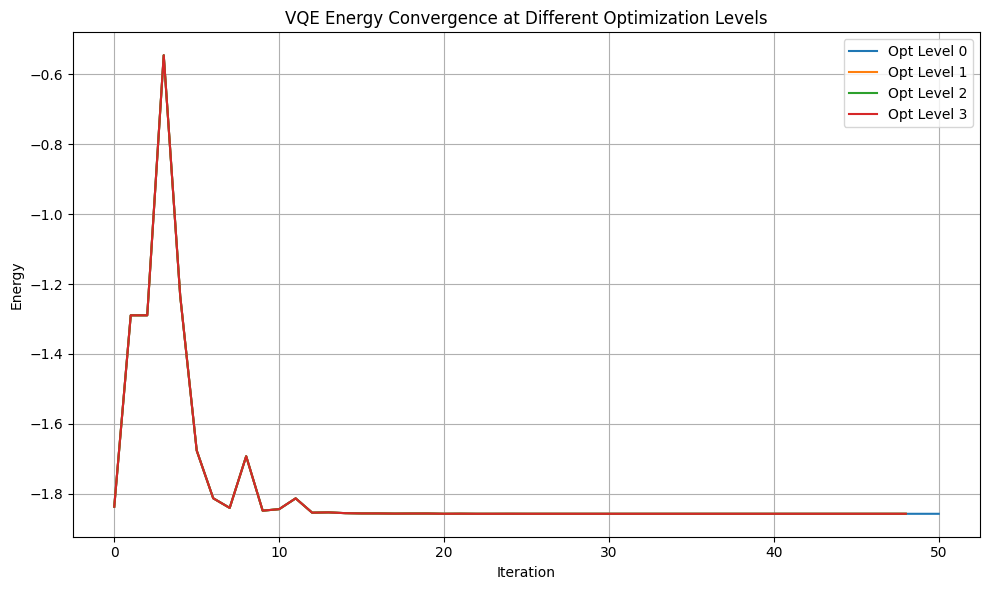

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
for level, history in convergence_data.items():
    plt.plot(history, label=f"Opt Level {level}")
plt.xlabel("Iteration")
plt.ylabel("Energy")
plt.title("VQE Energy Convergence at Different Optimization Levels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()